<a href="https://colab.research.google.com/github/patrickzoechbauer/beyondmcmc/blob/main/PoisRegSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Install numpyro as well as RAABBVI 

In [ ]:
!pip install numpyro
!pip install pystan==2.19.1.1
!pip install git+https://github.com/Manushi22/viabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 291 kB 14.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 77 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Manushi22/viabel to /tmp/pip-req-build-2_zfzsws
  Running command git clone -q https://github.com/Manushi22/viabel /tmp/pip-req-build-2_zfzsws
     |████████████████████████████████| 41 kB 181 kB/s 
  Created wheel for viabel: filename=viabel-0.4.2-py3-none-any.whl size=40398 sha256=f09c2c5cb6fdf27fc64865fe6fee3966088fcb0c2eb3023c39edfbb76a321c3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-ov2x47ue

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats
import random
import time 
import pickle

import numpyro
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist
#assert numpyro.__version__.startswith("0.9.2")

import jax.numpy as jnp
from jax.random import PRNGKey

from scipy.stats import multivariate_normal
from scipy.stats import genpareto
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

import viabel
from viabel.optimization import FASO, RMSProp, RAABBVI
from viabel.objectives import ExclusiveKL
from viabel.approximations import MFGaussian
from viabel.models import Model, StanModel
from viabel import bbvi, MFStudentT
from viabel.diagnostics import all_diagnostics 

import arviz

from tqdm.notebook import tqdm, trange
import os, sys

# Section 1: Define functions to train MCMC, ADVI and RAABBVI

In [ ]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
  
set_seed(42)

In [ ]:
def sample_data(N=10000, D = 100):
  x = np.random.normal(size = (N,D-1))
  beta = np.random.normal(size = (D-1,))

  intensity = np.exp(np.matmul(x, beta))
#  idx = np.where(intensity > 100)
#  x = np.delete(x, idx, axis = 0)

#  intensity = np.exp(np.matmul(x, beta))
  norm_factor = np.mean(intensity)/10
  intensity = intensity/norm_factor

  N,_ = x.shape
  x = np.c_[ x, np.ones(N) ]  
  beta = np.r_[beta, -np.log(norm_factor)]

  Y = np.random.poisson(intensity)

  cols = ["var"+str(i+1) for i in range(D-1)]
  cols.append("intercept")

  sigma = 0

  return Y, x, beta, sigma, cols, intensity

In [ ]:
# Defines probabilistc model for numpyro
def model(X, Y=None):
  N, D = X.shape
  beta = numpyro.sample('beta', dist.Normal(0.0, 1.0).expand([D]).to_event(1))

  with numpyro.plate('obs', N):
    intensity_est = jnp.exp(jnp.dot(X, beta[:,None]).reshape(-1))
    numpyro.sample('Y', dist.Poisson(rate = intensity_est), obs = Y)

In [ ]:
# Function to run MCMC with NUTS sampler
def run_mcmc(model, num_warmup, num_samples, num_chains, X, Y, summary = False):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
    )
    mcmc.run(PRNGKey(1), X, Y)
    if summary:
      mcmc.print_summary()
    return mcmc.get_samples()

In [ ]:
# Function to calculate PSIS for numpyro VI approx 
def calcPSIS(vi_guide, vi_params):
  #Step 3: Get samples \theta_s for s = 1,...,S

  S = 10000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))

  #Step 4: Calcualte the importance ratio
  #calc log(p(\theta_s, y))
  theta = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))['beta']
  lp_target = log_density(theta)
#  lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['Y'].sum(axis = 1)

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2

  #check if vi_cov singular
  det = np.linalg.det(vi_cov)
  if det < 0.00001:
      return 10

  var = multivariate_normal(mean=vi_mean, 
                            cov=vi_cov,
                            allow_singular = True)

  lp_vi = var.logpdf(theta)

  # calc the ratio
  lp_ratio = lp_target-lp_vi

  # Step 5: 
  #select largest M of lp_ratio
  M = int(np.min([S/5, 3*np.sqrt(S)]))
  log_rs_largest = np.partition(lp_ratio,-M)[-M:]

  _, k = arviz.psislw(log_rs_largest, 0.8)

  return k

In [ ]:
def H2(log_weights, alpha=2.):
  log_weights = np.asarray(log_weights)
  log_rescale = np.max(log_weights)

  rescaled_weights = np.exp(log_weights - log_rescale)**alpha
  mean_rescaled_weight = np.mean(rescaled_weights)
  cubo = np.log(mean_rescaled_weight) / alpha + log_rescale
  log_norm_bound = np.mean(log_weights)
  dalpha = alpha / (alpha - 1) * (cubo - log_norm_bound)
  return dalpha  

def WSBoundExpInt(log_weights, samples, p=1):
  d2 = H2(log_weights)
  epsilon = 1
  integral = np.log(np.mean(np.exp(epsilon*d2**p)))
  Cp = 2*((1/epsilon)*(3/2 + integral))**(1/p)
  bound = Cp*(d2**(1/p)+(d2*0.5)**(1/(2*p)))
  return {'W'+str(p):bound}

In [ ]:
def VIbounds(vi_guide, vi_params, expBound = False):
  S = 2000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))

  #Step 4: Calcualte the importance ratio
  #calc log(p(\theta_s, y))
  theta = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))['beta']
  lp_target = log_density(theta)

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2
  var = multivariate_normal(mean=vi_mean, 
                              cov=vi_cov)
  lp_vi = var.logpdf(theta)

  # calc the ratio
  log_weights = lp_target-lp_vi
  samples = theta

  if expBound == True: 
    bounds = WSBoundExpInt(log_weights, samples, p=2)
  else: 
    bounds = all_diagnostics(log_weights, samples = samples)

  return bounds

In [ ]:
def AnalyticalW2Bound(vi_params, vi_guide):
  #Calc C_2
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd
  vi_cov = np.matmul(vi_cov, vi_cov)
  #lambdas = np.linalg.eig(vi_cov)[0]
  epsilon = 0.1
  C = 2*((1/epsilon)*((3/2)+np.log((1-2*epsilon)**(-0.5)).sum()))**0.5

  #Approx. KL-divergence
  S = 2000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))

  #Step 4: Calcualte the importance ratio
  #calc log(p(\theta_s, y))
  theta = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))['beta']
  lp_target = log_density(theta)

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2
  var = multivariate_normal(mean=vi_mean, 
                              cov=vi_cov)
  lp_vi = var.logpdf(theta)

  # calc the ratio
  log_weights = lp_target-lp_vi

  d2 = H2(log_weights)
  p=2
  bound = C*(d2**(1/p)+(d2*0.5)**(1/(2*p)))

  return {'W2':bound}

In [ ]:
# Function to run ADVI with mean-field approximation
# Stopping criteria is based on relative improvement of ELBO as in Stan
from arviz.stats.diagnostics import rhat
def run_ADVI(model, guide_family, maxiter, X, Y, stopping = 'ELBO', tol = 10**(-2)):
    if guide_family == "AutoDelta":
        guide = autoguide.AutoDelta(model)
    elif guide_family == "AutoDiagonalNormal":
        guide = autoguide.AutoDiagonalNormal(model)

    optimizer = numpyro.optim.Adam(0.1)
    svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles = 10))
 
    svi_state = svi.init(PRNGKey(1), X=X, Y=Y)
    losses = []
    loss_old = 1
    W2old = 1

    pbar = tqdm(range(maxiter))
    t0 = time.time()
    for i in pbar:
      svi_state, loss_new = svi.update(svi_state, X=X, Y=Y)
      rel_err = jnp.abs((1-loss_new/loss_old))
        
      loss_old = loss_new
      losses.append(loss_new)
      
      if stopping == 'ELBO':
        pbar.set_postfix({'RelElbo': rel_err})
        if rel_err < tol: 
          print('Stopped after {} iterations with default tol of {}.'.format(i+1, tol))
          break
      if stopping == 'PSIS':
        params = svi.get_params(svi_state)
        k =  calcPSIS(guide, params)
        pbar.set_postfix({'k': k})
        if k < 0.7 and i >10: 
          print('Stopped after {} iterations because k = {:.2f}.'.format(i+1, k))
          break
      if stopping == 'wasserstein':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        rel_W2 = jnp.abs((1-bounds['W2']/W2old))

        pbar.set_postfix({'RelW2': rel_W2, 'W2':bounds['W2']})
        W2old = bounds['W2']
        #print(rel_W2)
        if rel_W2 < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break        

      if stopping == 'wasserstein_abs':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        pbar.set_postfix({'W2':bounds['W2']})
        if bounds['W2'] < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break   

      if stopping == 'time':
        trun = time.time()-t0
        if trun > tol:
          print('Stopped after {} iterations with time tol of {}.'.format(i+1, tol))
          break

      
      if stopping == 'rhat':
        W = 50
        params = svi.get_params(svi_state)      
        if i == 0: 
          loc = params['auto_loc']
          dim = loc.shape[0]
        else:
          loc = np.c_[loc, params['auto_loc']]
          #scale = np.c_[scale, params['auto_scale']]
        if i > 2*W:
          rhat_array = []
          for l in range(dim):
            locl = loc[l,:]
            k = i-2*W
            chain = np.stack((locl[k:k+W],locl[k+W:k+2*W]))
            rhat_array.append(rhat(chain))
          
          if np.mean(rhat_array) < 2:
            print('Stopped after {} iterations with rhat of {}.'.format(i+1, tol))
            break

    losses = jnp.stack(losses)
    params = svi.get_params(svi_state)

    return losses, params, guide

In [ ]:
# Functions to run VI using RAAABBVI
def log_density2(theta):  
    #Dimensions is D+1+N
    import autograd.numpy as np
    import autograd.scipy.stats.norm as norm
    import autograd.scipy.stats.gamma as gamma
    import autograd.scipy.stats.poisson as poisson
    mc = theta.shape[0]
    beta_q = theta[:,0:D]
    intensity = np.exp(np.tensordot(X, beta_q.T, axes = 1))

    lik = 0
    for i in range(mc):
      lik+=(np.sum(poisson.logpmf(y, intensity[:,i]))+np.sum(norm.logpdf(beta_q[i,:], 0, 1))) 

    return lik/mc #beta_density + poisson_density

def log_density(theta):  
    #Dimensions is D+1+N
    import autograd.numpy as np
    import autograd.scipy.stats.norm as norm
    import autograd.scipy.stats.gamma as gamma
    import autograd.scipy.stats.poisson as poisson

    beta_q = theta[:,0:D]
    
    #Draws: 
    beta_q = beta_q.mean(axis = 0).squeeze()
    
    #Priors: 
    beta_density = np.sum(norm.logpdf(beta_q, 0, 1)) 

    #likelihood 
    intensity = np.exp(np.dot(X, beta_q)) #+noise_q)
    poisson_density = np.sum(poisson.logpmf(y, intensity))

    return beta_density + poisson_density


def raabbvi(dimension, n_iters=10000, num_mc_samples=100, log_density=None, 
            learning_rate=1, RMS_kwargs={'diagnostics':True}, FASO_kwargs=dict()):
    """Fit a model using black-box variational inference.
    """
    model = Model(log_density)
    approx = MFGaussian(dimension)
    objective = ExclusiveKL(approx, model, num_mc_samples)
    init_var_param = approx.init_param()

    base_opt = RMSProp(learning_rate, **RMS_kwargs)
    #opt = FASO(base_opt, **FASO_kwargs)
    opt = RAABBVI(base_opt, **FASO_kwargs)

    opt_results = opt.optimize(n_iters, objective, init_var_param)
    opt_results['objective'] = objective
    return opt_results, approx


def raabbviStan(dimension, n_iters=10000, num_mc_samples=10, fit=None, 
                learning_rate=1, RMS_kwargs={'diagnostics':True}, FASO_kwargs=dict()):
    """Fit a model using black-box variational inference.
    """
    model = StanModel(fit)
    approx = MFGaussian(dimension)
    objective = ExclusiveKL(approx, model, num_mc_samples)
    init_var_param = approx.init_param()

    base_opt = RMSProp(learning_rate, **RMS_kwargs)
    #opt = FASO(base_opt, **FASO_kwargs)
    opt = RAABBVI(base_opt, **FASO_kwargs)

    opt_results = opt.optimize(n_iters, objective, init_var_param)
    opt_results['objective'] = objective
    return opt_results, approx    

In [ ]:
import pystan
stan_code = """
data{
    int N;
    int D;
    matrix[N,D] X;
    int Y[N];
}
parameters{
    vector[D] beta;
}
model{
    beta ~ normal(0, 1);
    Y ~ poisson_log(X * beta);
}
"""

sm = pystan.StanModel(model_code=stan_code)

In [ ]:
# Plot posterior distriutions against ground truth
def plotResults(loc):
  samples_mcmc = np.c_[posterior_samples['beta'].to_py()]

  samples_vi = np.c_[vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['beta'].to_py()]

                      
  samples_mcmc = posterior_samples['beta'].to_py()
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['beta'].to_py()
  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)
  #samples_raabbvi[:,D] = np.exp(samples_raabbvi[:,D])

  #cols_used = cols.copy()
  #cols_used.append('sigma')
  cols_used = [r'$\beta_1$', r'$\beta_2$', r'$\beta_0$']

  fig, ax = plt.subplots(figsize=(4,3))
  labels = []

  v1 = ax.violinplot(
      [samples_mcmc[:, i] for i in range(len(cols_used))]
      )
  c1 = v1['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c1), 'MCMC'))

  v2 = ax.violinplot(
      [samples_vi[:, i] for i in range(len(cols_used))]
      )
  c2 = v2['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c2), 'ADVI'))

  v3 = ax.violinplot(
      [samples_raabbvi[:, i] for i in range(len(cols_used))]
      )
  c3 = v3['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c3), 'RAABBVI'))

  #add ground truth
  ground_truth = np.r_[beta, sigma]
  for i in range(len(cols_used)):
    ax.hlines(y=ground_truth[i], xmin=(i+1)-0.1, xmax=(i+1)+0.1, linewidth=2, color='r')

  ax.set_xticks(np.arange(1, len(cols_used) + 1))
  ax.set_xticklabels(cols_used, fontsize=10)
  ax.legend(*zip(*labels), loc=loc)
  plt.title("Poisson regression")

In [ ]:
# Performance on the mean:
def MADstats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.mean(axis = 0)
  MAD_mu = np.abs((samples - groundTruth)).mean(axis = 0)
  MAD_beta_mu = MAD_mu[0:D].mean()
  #MAD_sigma_mu = MAD_mu[D]
  return [MAD_beta_mu], [] #, [MAD_sigma_mu]   

def varianceStats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.std(axis = 0)
  samplesStd = samples.std(axis = 0)
  MAD_std = ((samplesStd-groundTruth))
  MAD_beta_std = MAD_std[0:D].mean()
  #MAD_sigma_std = MAD_std[D]
  return [MAD_beta_std], []#, [MAD_sigma_std]

def getPerformance(D):
  ground_truth = beta

  samples_mcmc = posterior_samples['beta'].to_py()

  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['beta'].to_py()                   

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)

  # Calculate mean performance:

  MAD_advi_beta_mu, _ = MADstats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_mu, _ = MADstats(samples_raabbvi, samples_mcmc, D)

  result_mu = {('beta', 'advi'): MAD_advi_beta_mu,
                ('beta', 'raabbvi'): MAD_raabbvi_beta_mu}

  resDf_mu = pd.DataFrame(result_mu)

  # Calculate std performance:

  MAD_advi_beta_std, _ = varianceStats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_std, _ = varianceStats(samples_raabbvi, samples_mcmc, D)

  result_std = {('beta', 'advi'): MAD_advi_beta_std,
              ('beta', 'raabbvi'): MAD_raabbvi_beta_std}

  resDf_std = pd.DataFrame(result_std)

  # Calculate wasserstein distance: 

  W_mu_advi = []
  W_mu_raabbvi = []
  for i in range(D):
    W_mu_advi.append(wasserstein_distance(samples_mcmc[:,i], samples_vi[:,i]))
    W_mu_raabbvi.append(wasserstein_distance(samples_mcmc[:,i], samples_raabbvi[:,i]))

  W_mu_advi = np.array(W_mu_advi).mean()
  W_mu_raabbvi = np.array(W_mu_raabbvi).mean()

  result_W = {('beta', 'advi'): [W_mu_advi],
              ('beta', 'raabbvi'): [W_mu_raabbvi]}

  resDf_W = pd.DataFrame(result_W)

  # Calculate KS-test p-value

  KS_mu_advi = []
  KS_mu_raabbvi = []
  for i in range(D):
    _, p_value_advi = ks_2samp(samples_mcmc[:,i], samples_vi[:,i])

    KS_mu_advi.append(p_value_advi)

    _, p_value_raabbvi = ks_2samp(samples_mcmc[:,i], samples_raabbvi[:,i])

    KS_mu_raabbvi.append(p_value_raabbvi)

  KS_mu_advi = np.amin(np.array(KS_mu_advi))
  KS_mu_raabbvi = np.amin(np.array(KS_mu_raabbvi))

  result_KS = {('beta', 'advi'): [KS_mu_advi],
              ('beta', 'raabbvi'): [KS_mu_raabbvi]}

  resDf_KS = pd.DataFrame(result_KS)

  return resDf_mu, resDf_std, resDf_W, resDf_KS

# Section 2: Run MCMC, ADVI and RAABBVI on sample data

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


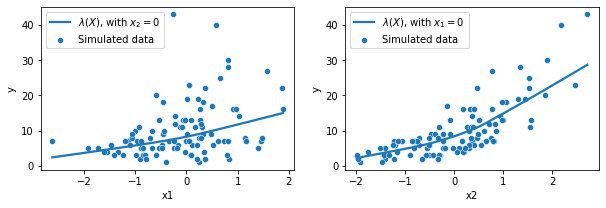

In [ ]:
# Generate data for linear regression
D = 3
N = 100
y, X, beta, sigma, cols, intensity = sample_data(N=N, D = D)

X1, X2 = X.copy(), X.copy()
X1[:,1], X2[:,0] = np.zeros(X1[:,1].shape), np.zeros(X2[:,0].shape)
y_exact1 = np.exp(np.matmul(X1, beta))
y_exact2 = np.exp(np.matmul(X2, beta))

# Univariate plot of first dimension 
#df = pd.DataFrame({'x':X[:,0], 'y':y, 'y_exact':beta[1]+beta[0]*X[:,0]})
df = pd.DataFrame(np.c_[X1, y, y_exact1], columns = ['x1', 'x2', 'intercept', 'y', 'y_exact'])
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
sns.scatterplot(data = df, x='x1', y='y', ax = ax[0], 
                label = 'Simulated data')
sns.regplot(data = df, x='x1', y='y_exact', ax = ax[0],
                label = '$\lambda(X)$, with $x_2 = 0$',
                scatter = False,
                ci = None,
                lowess=True)
ax[0].set_ylabel('y', fontsize=10)
ax[0].legend(loc="best")

df = pd.DataFrame(np.c_[X2, y, y_exact2], columns = ['x1', 'x2', 'intercept', 'y', 'y_exact'])
sns.scatterplot(data = df, x='x2', y='y', ax = ax[1], 
                label = 'Simulated data')
sns.regplot(data = df, x='x2', y='y_exact', ax = ax[1],
                label = '$\lambda(X)$, with $x_1 = 0$',
                scatter = False,
                ci = None,
                lowess=True)
ax[1].set_ylabel('y', fontsize=10)
ax[1].legend(loc="best")
plt.savefig('simulated_data_pois.pdf')  

In [ ]:
# Run MCMC, ADVI and RAABBVI and plot results
import warnings
print('Inference using MCMC:')
t0 = time.time()
posterior_samples = run_mcmc(model, 2000, 2000, 1, X, y, False)
print(time.time()-t0)
print('---------------------\n')
print('Inference using ADVI:')
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 500, 
                                            X, y, tol = 0.01, 
                                            stopping = 'ELBO')
print('---------------------\n')
print('Inference using RAABBVI:')
#results, approx = raabbvi(D, log_density=log_density2) # num_mc_samples=10, n_iters = 10000)
data = {"N":N, "D":D, "X":X, "Y":y}
fit = sm.sampling(data = data, iter = 100)
results, approx = raabbviStan(D, fit = fit, 
                              n_iters = 100000,
                              learning_rate=0.1) # num_mc_samples=10, n_iters = 10000)

Inference using MCMC:


sample: 100%|██████████| 4000/4000 [00:06<00:00, 600.67it/s, 3 steps of size 7.45e-01. acc. prob=0.88]


6.751572132110596
---------------------

Inference using ADVI:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 23 iterations with default tol of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 5.3909e+12 | R hat converged|:   1%|          | 1200/100000 [00:01<02:17, 717.27it/s]


Convergence reached at iteration 1200


average loss = -1,453.9 | R hat converged|:   1%|          | 915/98799 [00:01<02:17, 713.20it/s]

Convergence reached at iteration 915



average loss = -1,455 | R hat converged|:   1%|          | 621/97883 [00:00<02:19, 699.27it/s]

Convergence reached at iteration 621



average loss = -1,455.3 | R hat converged|:   2%|▏         | 1471/97261 [00:02<02:22, 670.81it/s]


Convergence reached at iteration 1471
Termination rule reached at iteration 4207
Inefficiency Index: 1.0007296691217162


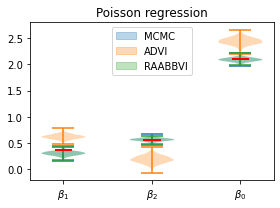

In [ ]:
plotResults('upper center')
plt.tight_layout()
plt.savefig('experiment1_pois.pdf')  

# Section 3: Simulation studies 

## Section 3.1: How well does the stopping criterion, that was proposed in the original ADVI paper work?

In [ ]:
# Run simulation expertiment: 
# Research question: How does standard ADVI compare against RAABBVI?
# This simulation compares the MAD for mean and std for linear regression  
# Note: For std the MCMC estimate is used as the ground truth
resultMu = {('beta', 'advi'): [],
          ('beta', 'raabbvi'): []}

resDfMu = pd.DataFrame(resultMu)

resultStd = {('beta', 'advi'): [],
              ('beta', 'raabbvi'): []}

resDfStd = pd.DataFrame(resultStd)

resultW = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfW = pd.DataFrame(resultW)

resultKS = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfKS = pd.DataFrame(resultKS)

N = 250
D = 5

i=0
while (i < 10):
  print('\nIteration: {} of 10'.format(i+1))
  print('-------------------------')
  y, X, beta, sigma, cols, intensity = sample_data(N=N, D = D)
  with HiddenPrints():
    posterior_samples = run_mcmc(model, 2000, 2000, 1, X, y)
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 10000, 
                                            X, y, tol = 0.01, 
                                            stopping = 'ELBO')
    data = {"N":N, "D":D, "X":X, "Y":y}
    fit = sm.sampling(data = data, iter = 10)
    try:
      results, approx = raabbviStan(D, fit = fit, 
                                    n_iters = 100000,
                                    num_mc_samples = 10,
                                    learning_rate = 0.1)
    except:
      print('Error in raabbvi')
      continue
    
  print('RAABBVI')
  resMu_i, resStd_i, resW_i, resKS_i = getPerformance(D)
  resDfMu = resDfMu.append(resMu_i)
  resDfStd = resDfStd.append(resStd_i)
  resDfW = resDfW.append(resW_i)
  resDfKS = resDfKS.append(resKS_i)
  i+=1


Iteration: 1 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 576.01it/s, 15 steps of size 3.09e-01. acc. prob=0.94] 


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = 2.5453e+29 | R hat not converged|:   1%|          | 600/100000 [00:00<02:42, 612.99it/s]
average loss = -6,580.3 | R hat converged|:   3%|▎         | 3323/99399 [00:05<02:47, 574.12it/s]
average loss = -6,590 | R hat converged|:   1%|          | 882/96075 [00:01<02:39, 595.09it/s]
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


RAABBVI


  0%|          | 0/4000 [00:00<?, ?it/s]


Iteration: 2 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 595.35it/s, 7 steps of size 6.21e-01. acc. prob=0.89] 


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = 1.8165e+05 | R hat not converged|:   2%|▏         | 2000/100000 [00:03<02:45, 591.70it/s]
average loss = -4,628.6 | R hat converged|:   1%|          | 582/97999 [00:00<02:44, 592.80it/s]
average loss = -4,633.7 | R hat converged|:   1%|          | 930/97416 [00:01<02:46, 578.63it/s]
average loss = -4,635 | R hat converged|:   1%|          | 1080/96485 [00:01<02:50, 559.27it/s]
average loss = -4,635.4 | R hat converged|:   4%|▎         | 3542/95404 [00:06<02:42, 563.96it/s]
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 3 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 579.35it/s, 7 steps of size 1.77e-01. acc. prob=0.93] 


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = -11,809 | R hat converged|: 100%|██████████| 100000/100000 [02:58<00:00, 559.60it/s]
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 4 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:07<00:00, 564.95it/s, 15 steps of size 2.56e-01. acc. prob=0.94] 


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = -7,416.1 | R hat converged|: 100%|██████████| 100000/100000 [02:55<00:00, 569.59it/s]
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 5 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 590.93it/s, 15 steps of size 3.22e-01. acc. prob=0.92]


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = 3.4727e+41 | R hat not converged|:   0%|          | 400/100000 [00:00<02:44, 606.00it/s]
average loss = 1.3081e+30 | R hat not converged|:   1%|          | 800/99599 [00:01<02:42, 606.20it/s]
average loss = -7,375.5 | R hat converged|:   3%|▎         | 2673/98798 [00:04<02:42, 589.75it/s]
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 6 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 577.46it/s, 15 steps of size 1.81e-01. acc. prob=0.94]


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = -9,166.2 | R hat converged|: 100%|██████████| 100000/100000 [02:55<00:00, 571.00it/s]
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 7 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 574.52it/s, 31 steps of size 1.74e-01. acc. prob=0.94]


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = 6.9547e+33 | R hat converged|:   1%|          | 508/100000 [00:00<02:46, 598.55it/s]
  0%|          | 0/4000 [00:00<?, ?it/s]


Iteration: 7 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 573.79it/s, 15 steps of size 2.02e-01. acc. prob=0.94]


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = -9,082.9 | R hat converged|:   3%|▎         | 3390/100000 [00:05<02:49, 569.85it/s]
average loss = -9,127.3 | R hat converged|:   1%|▏         | 1277/96609 [00:02<02:44, 580.87it/s]
average loss = -9,138.5 | R hat converged|:   2%|▏         | 1576/95331 [00:02<02:48, 555.98it/s]
average loss = -9,141.2 | R hat converged|:   2%|▏         | 1974/93754 [00:03<02:41, 567.79it/s]
average loss = -9,141.9 | R hat converged|:   4%|▍         | 3479/91779 [00:06<02:37, 559.88it/s]
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 8 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 588.12it/s, 15 steps of size 4.53e-01. acc. prob=0.92]


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = -5,207.9 | R hat converged|:   3%|▎         | 3395/100000 [00:05<02:48, 573.07it/s]
average loss = -5,252.8 | R hat converged|:   1%|          | 1075/96604 [00:01<02:46, 574.25it/s]
average loss = -5,263.6 | R hat converged|:   1%|          | 916/95528 [00:01<02:48, 562.36it/s]
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 9 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:07<00:00, 552.82it/s, 15 steps of size 2.34e-01. acc. prob=0.93]


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = -7,346.5 | R hat converged|: 100%|██████████| 100000/100000 [02:58<00:00, 560.10it/s]
/usr/local/lib/python3.7/dist-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)
  0%|          | 0/4000 [00:00<?, ?it/s]

RAABBVI

Iteration: 10 of 10
-------------------------


sample: 100%|██████████| 4000/4000 [00:06<00:00, 594.03it/s, 7 steps of size 7.41e-01. acc. prob=0.88] 


  0%|          | 0/10000 [00:00<?, ?it/s]

average loss = 1.645e+26 | R hat converged|:   1%|          | 862/100000 [00:01<02:49, 585.13it/s]
average loss = 4.5375e+06 | R hat converged|:   1%|▏         | 1294/99137 [00:02<02:49, 578.14it/s]
average loss = -3,619.2 | R hat converged|:   1%|          | 1168/97842 [00:02<02:46, 580.91it/s]


RAABBVI


In [ ]:
#Output for \mu-MAD
df = resDfMu.reindex(columns=['beta'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_mu_MAD.txt', index = False)

#Output for \sigma-MAD
df = resDfStd.reindex(columns=['beta', 'sigma'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_sigma_MAD.txt', index = False)

#Output for Wasserstein
df = resDfW.reindex(columns=['beta', 'sigma'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_W.txt', index = False)

#Output for KS
df = resDfKS.reindex(columns=['beta', 'sigma'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(5).to_latex('sim1_KS.txt', index = False)


In [ ]:
#Output for \mu-MAD
df = resDfMu.reindex(columns=['beta'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2)

,,advi,raabbvi
0,beta,0.71,0.02


## Section 3.2: Is RAABBVI always better than ADVI or does it only depend on the stopping criteria?

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
result = dict()
times = dict()
simTotal = 5
maxLog2T = 10

timesteps = [2**i for i in range(maxLog2T)]

for nsim in range(simTotal):
  print(nsim)

  #Is RAABBVI always better than ADVI? Or does it just depand on the stopping criteria?
  N = 250
  D = 5
  y, X, beta, sigma, cols, intensity = sample_data(N=N, D = D)
  ground_truth = beta
  k=0

  # Get MCMC perfomance
  t0 = time.time()
  posterior_samples = run_mcmc(model, 2000, 2000, 1, X, y)
  print(time.time()-t0)
  samples_mcmc = posterior_samples['beta'].to_py()

  # Get RAABVI performance
  t0_raabbvi = time.time()
  data = {"N":N, "D":D, "X":X, "Y":y}
  fit = sm.sampling(data = data, iter = 10)
  try:
      results, approx = raabbviStan(D, fit = fit, 
                                    n_iters = 100000,
                                    num_mc_samples = 10,
                                    learning_rate = 0.1)
  except:
      print('Error in raabbvi')
      continue
  t_raabbvi = time.time()-t0_raabbvi

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)
  

  # Get ADVI performance for different number of iterations
  for k in timesteps:
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 20000, 
                                                  X, y, stopping = 'time', tol = k)
    
    samplesVI = vi_guide.sample_posterior(PRNGKey(1), 
                                                vi_params, 
                                                (2000,))['beta'].to_py()

    result[(k, nsim, 'ADVI', 'MAD', 'beta')], _ = \
      MADstats(samplesVI, samples_mcmc, D)

    result[(k, nsim, 'ADVI', 'varErr', 'beta')], _ = \
      varianceStats(samplesVI, samples_mcmc, D)

    result[(k, nsim, 'RAABBVI', 'MAD', 'beta')], _ = \
      MADstats(samples_raabbvi, samples_mcmc, D)

    result[(k, nsim, 'RAABBVI', 'varErr', 'beta')], _ = \
      varianceStats(samples_raabbvi, samples_mcmc, D)


    result[(k, nsim, 'RAABBVI', 'time', '')] = t_raabbvi

    result[(k, nsim, 'ADVI', 'time', '')] = k

  #save results
  file_to_write = open("gdrive/My Drive/experiment1_pois_results.pickle", "wb")
  pickle.dump(result, file_to_write)

0


sample: 100%|██████████| 4000/4000 [00:06<00:00, 600.35it/s, 23 steps of size 3.93e-01. acc. prob=0.93] 


8.382236957550049


Using cached StanModel for weighted_lin_regression


average loss = 6.4865e+34 | R hat converged|:   0%|          | 486/100000 [00:00<02:46, 596.65it/s]


Convergence reached at iteration 486


average loss = -5,175.9 | R hat converged|: 100%|██████████| 99513/99513 [02:57<00:00, 560.04it/s]


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 1 iterations with time tol of 1.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 29 iterations with time tol of 2.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 64 iterations with time tol of 4.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 125 iterations with time tol of 8.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 256 iterations with time tol of 16.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 516 iterations with time tol of 32.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 1014 iterations with time tol of 64.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 1999 iterations with time tol of 128.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 3983 iterations with time tol of 256.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 7948 iterations with time tol of 512.
1


sample: 100%|██████████| 4000/4000 [00:07<00:00, 569.60it/s, 15 steps of size 3.30e-01. acc. prob=0.91]


7.4691667556762695


Using cached StanModel for weighted_lin_regression


average loss = 73,857 | R hat converged|:   2%|▏         | 2262/100000 [00:03<02:49, 576.48it/s]


Convergence reached at iteration 2262


average loss = -6,162.2 | R hat converged|:   1%|          | 880/97737 [00:01<02:49, 572.96it/s]


Convergence reached at iteration 880


average loss = -6,171.1 | R hat converged|:   1%|          | 782/96856 [00:01<02:42, 592.47it/s]

Convergence reached at iteration 782


Termination rule reached at iteration 3924
Inefficiency Index: 3.0516472179863454


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 14 iterations with time tol of 1.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 32 iterations with time tol of 2.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 65 iterations with time tol of 4.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 128 iterations with time tol of 8.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 254 iterations with time tol of 16.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 506 iterations with time tol of 32.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 1007 iterations with time tol of 64.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 1987 iterations with time tol of 128.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 3980 iterations with time tol of 256.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 7848 iterations with time tol of 512.
2


sample: 100%|██████████| 4000/4000 [00:07<00:00, 569.55it/s, 15 steps of size 4.24e-01. acc. prob=0.92]


7.482732772827148


Using cached StanModel for weighted_lin_regression


average loss = -5,602.8 | R hat converged|: 100%|██████████| 100000/100000 [02:56<00:00, 565.65it/s]


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 14 iterations with time tol of 1.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 31 iterations with time tol of 2.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 62 iterations with time tol of 4.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 125 iterations with time tol of 8.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 249 iterations with time tol of 16.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 494 iterations with time tol of 32.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 986 iterations with time tol of 64.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 1989 iterations with time tol of 128.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 3959 iterations with time tol of 256.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 7878 iterations with time tol of 512.
3


sample: 100%|██████████| 4000/4000 [00:06<00:00, 574.30it/s, 15 steps of size 3.69e-01. acc. prob=0.91]


7.411120176315308


Using cached StanModel for weighted_lin_regression


average loss = 8.1259e+31 | R hat not converged|:   0%|          | 400/100000 [00:00<02:44, 603.96it/s]


Convergence reached at iteration 400


average loss = -7,236.9 | R hat converged|: 100%|██████████| 99599/99599 [02:55<00:00, 567.00it/s]


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 14 iterations with time tol of 1.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 31 iterations with time tol of 2.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 63 iterations with time tol of 4.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 126 iterations with time tol of 8.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 251 iterations with time tol of 16.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 492 iterations with time tol of 32.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 994 iterations with time tol of 64.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 1974 iterations with time tol of 128.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 3856 iterations with time tol of 256.


  0%|          | 0/20000 [00:00<?, ?it/s]

Stopped after 7598 iterations with time tol of 512.
4


sample: 100%|██████████| 4000/4000 [00:07<00:00, 519.00it/s, 15 steps of size 2.79e-01. acc. prob=0.94]


8.197994947433472


Using cached StanModel for weighted_lin_regression


average loss = 9.6155e+37 | R hat not converged|:   1%|          | 800/100000 [00:01<02:54, 568.13it/s]

Error in raabbvi


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


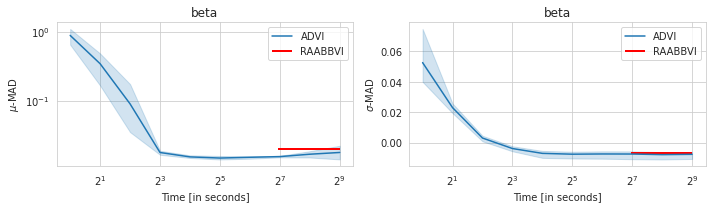

In [ ]:
file_res = open("gdrive/My Drive/experiment1_pois_results.pickle",'rb')
result = pickle.load(file_res)

df = pd.DataFrame(result).stack(level = [0,1])
df.index = df.index.droplevel(level = 0)
df.reset_index(inplace = True)

def plotSimulation1(colname, kpi, df, ax):
  dfMAD = df.loc[:, (slice(None), kpi, colname)]
  dfMAD.columns = [col[0] for col in dfMAD.columns]
  dfMAD = dfMAD.reset_index()
  dfMAD.drop(columns = ['index'], inplace = True)

  if time: 
    dfMAD['t_advi'] = df.loc[:, ('ADVI', 'time')].values
    dfMAD['t_raabbvi'] = df.loc[:, ('RAABBVI', 'time')].values

    tmin = dfMAD['t_advi'].min()
    tmax = dfMAD['t_advi'].max()

    sns.lineplot(data = dfMAD, x = 't_advi', y = 'ADVI', ax = ax,
                 label = 'ADVI')

    t_RAABBVI = dfMAD['t_raabbvi'].mean()
    val_RAABBVI = dfMAD['RAABBVI'].mean()

    ax.hlines(y=val_RAABBVI, xmin=t_RAABBVI, xmax=dfMAD['t_advi'].max(), 
              linewidth=2, color='r', label = 'RAABBVI')

    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Time [in seconds]')
    ax.legend(loc="best")
    if kpi == 'MAD':   
      ax.set_ylabel('$\mu$-MAD')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('$\sigma$-MAD')

  else:
    dfMAD['k'] = 2**df['level_0']

    dfMAD_melted = dfMAD.melt('k', var_name='Method', value_name=kpi)
    sns.set_style('whitegrid')

    sns.lineplot(data = dfMAD_melted, x = 'k', y = kpi, hue = 'Method', 
                      style = 'Method', ax = ax)
    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Number of iterations $k$')
    if kpi == 'MAD':   
      ax.set_ylabel('$\mu$-MAD')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('$\sigma$-MAD')
      
sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
plotSimulation1('beta', 'MAD', df, ax[0])
plotSimulation1('beta', 'varErr', df, ax[1])
plt.tight_layout()
plt.savefig('gdrive/My Drive/experiment2pois_mu.pdf')  

## Section 3.3: Are there alternative stopping criteria for ADVI that match the performance of RAABBVI?

In [ ]:
# Run simulation with different stopping criteria: 
# 1: Relative improvement in ELBO 
# 2: PSIS k < 0.7 
# 3: Relative improvement in W2 bound 
# 4: RAABBVI 
# 5: MCMC
# 6: rhat
# Output: 

result = {}
for k in range(5):
  N = 250
  D = 5
  y, X, beta, sigma, cols, intensity = sample_data(N=N, D = D)

  import warnings
  print('Inference using MCMC:')
  posterior_samples = run_mcmc(model, 2000, 2000, 1, X, y, False)
  samples_mcmc = posterior_samples['beta'].to_py()


  print('---------------------\n')
  for rule in ['ELBO', 'wasserstein', 'PSIS', 'rhat']:
    print('Inference using ADVI with {}:'.format(rule))
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 1000, 
                                                X, y, tol = 0.01, 
                                                stopping = rule)
      samplesVI = vi_guide.sample_posterior(PRNGKey(1), 
                                                  vi_params, 
                                                  (2000,))['beta'].to_py()

      result[(k, 'MAD', 'beta', rule)], _ = \
        MADstats(samplesVI, samples_mcmc, D)

      result[(k, 'varErr', 'beta', rule)], _ = \
        varianceStats(samplesVI, samples_mcmc, D)

  print('---------------------\n')
  print('Inference using RAABBVI:')
  # Get RAABVI performance
  t0_raabbvi = time.time()
  data = {"N":N, "D":D, "X":X, "Y":y}
  fit = sm.sampling(data = data, iter = 10)
  try:
      results, approx = raabbviStan(D, fit = fit, 
                                    n_iters = 100000,
                                    num_mc_samples = 10,
                                    learning_rate = 0.1)
  except:
      print('Error in raabbvi')
      continue
  t_raabbvi = time.time()-t0_raabbvi
  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)
  result[(k, 'MAD', 'beta', 'RAABBVI')], _ = \
    MADstats(samples_raabbvi, samples_mcmc, D)

  result[(k, 'varErr', 'beta', 'RAABBVI')], _ = \
    varianceStats(samples_raabbvi, samples_mcmc, D)

#save results
file_to_write = open("gdrive/My Drive/experiment3_pois_results.pickle", "wb")
pickle.dump(result, file_to_write)

Inference using MCMC:


sample: 100%|██████████| 4000/4000 [00:06<00:00, 595.43it/s, 7 steps of size 4.58e-01. acc. prob=0.92]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 60 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 81 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 12 iterations because k = 0.21.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 131 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:


Using cached StanModel for weighted_lin_regression


average loss = 81,028 | R hat not converged|:   3%|▎         | 2800/100000 [00:04<02:42, 598.53it/s]


Convergence reached at iteration 2800


average loss = -5,575 | R hat converged|:   1%|          | 1008/97199 [00:01<02:38, 606.54it/s]


Convergence reached at iteration 1008


average loss = -5,583 | R hat converged|:   1%|▏         | 1218/96190 [00:02<02:38, 597.74it/s]

Convergence reached at iteration 1218



average loss = -5,585 | R hat converged|:   1%|▏         | 1196/94971 [00:02<02:37, 593.71it/s]

Convergence reached at iteration 1196



average loss = -5,585.5 | R hat converged|:   3%|▎         | 3027/93774 [00:05<02:39, 569.62it/s]

Convergence reached at iteration 3027


Termination rule reached at iteration 9249
Inefficiency Index: 1.2500189204716963
Inference using MCMC:


sample: 100%|██████████| 4000/4000 [00:06<00:00, 587.70it/s, 15 steps of size 1.67e-01. acc. prob=0.94]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 11 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 5 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 12 iterations because k = -0.03.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 302 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:


Using cached StanModel for weighted_lin_regression


average loss = -9,697.8 | R hat converged|:   3%|▎         | 3353/100000 [00:05<02:43, 590.89it/s]


Convergence reached at iteration 3353


average loss = -9,772.8 | R hat converged|:   1%|          | 1065/96646 [00:01<02:44, 581.82it/s]

Convergence reached at iteration 1065



average loss = -9,791.4 | R hat converged|:   2%|▏         | 1571/95580 [00:02<02:40, 587.41it/s]

Convergence reached at iteration 1571



average loss = -9,796 | R hat converged|:   2%|▏         | 2265/94008 [00:03<02:36, 584.38it/s]

Convergence reached at iteration 2265



average loss = -9,797.1 | R hat converged|:   4%|▍         | 3605/91742 [00:06<02:35, 565.34it/s]


Convergence reached at iteration 3605
Termination rule reached at iteration 11859
Inefficiency Index: 1.2438950350235733
Inference using MCMC:


sample: 100%|██████████| 4000/4000 [00:06<00:00, 593.52it/s, 7 steps of size 4.67e-01. acc. prob=0.91]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 46 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 31 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 18 iterations because k = 0.32.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 107 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:


Using cached StanModel for weighted_lin_regression


average loss = 1.494e+35 | R hat not converged|:   1%|          | 1200/100000 [00:01<02:40, 615.27it/s]


Convergence reached at iteration 1200


average loss = 1.0183e+05 | R hat converged|:   1%|▏         | 1437/98799 [00:02<02:46, 586.47it/s]

Convergence reached at iteration 1437



average loss = -4,852.3 | R hat converged|:   1%|          | 819/97361 [00:01<02:42, 595.66it/s]

Convergence reached at iteration 819



average loss = -4,854.1 | R hat converged|:   2%|▏         | 1717/96541 [00:03<02:46, 568.88it/s]


Convergence reached at iteration 1717


average loss = -4,854.6 | R hat converged|:   3%|▎         | 3210/94823 [00:05<02:38, 577.48it/s]


Convergence reached at iteration 3210


average loss = -4,854.8 | R hat converged|:  13%|█▎        | 12274/91612 [00:21<02:18, 572.64it/s]


Convergence reached at iteration 12274
Termination rule reached at iteration 20657
Inefficiency Index: 1.127499887176648
Inference using MCMC:


sample: 100%|██████████| 4000/4000 [00:06<00:00, 582.16it/s, 15 steps of size 3.27e-01. acc. prob=0.91]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 17 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 84 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 12 iterations because k = 0.17.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 130 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:


Using cached StanModel for weighted_lin_regression


average loss = 1.5379e+37 | R hat converged|:   1%|          | 593/100000 [00:01<02:56, 563.15it/s]


Error in raabbvi
Inference using MCMC:


sample: 100%|██████████| 4000/4000 [00:07<00:00, 568.04it/s, 31 steps of size 2.06e-01. acc. prob=0.94]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 9 iterations with default tol of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 5 iterations with W2 tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 12 iterations because k = 0.09.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 618 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:


Using cached StanModel for weighted_lin_regression


average loss = 9.0285e+39 | R hat not converged|:   0%|          | 400/100000 [00:00<02:52, 577.78it/s]


Convergence reached at iteration 400


average loss = -8,856.6 | R hat converged|:   3%|▎         | 3174/99599 [00:05<02:49, 568.63it/s]


Convergence reached at iteration 3174


average loss = -8,868.3 | R hat converged|:   1%|          | 1015/96424 [00:01<02:54, 547.25it/s]

Convergence reached at iteration 1015



average loss = -8,871.1 | R hat converged|:   3%|▎         | 2590/95408 [00:04<02:52, 539.56it/s]

Convergence reached at iteration 2590


Termination rule reached at iteration 7179
Inefficiency Index: 1.4431657190202043


FileNotFoundError: ignored

In [ ]:
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('MAD', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_mu.txt')

df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('varErr', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_sigma.txt')

In [ ]:
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('MAD', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2)

col2,ELBO,PSIS,RAABBVI,rhat,wasserstein
col1,,,,,
beta,0.62,1.01,0.01,0.03,0.46


In [ ]:
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('varErr', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2)

col2,ELBO,PSIS,RAABBVI,rhat,wasserstein
col1,,,,,
beta,0.04,0.05,-0.01,-0.01,0.03
